## Dry years plot for region

#this code uses a polygon supplied by GW

This notebook starts by using gridded daily BoM data to find wet and dry years using the available BoM data (oct 1987 - oct 2012). We find driest years as the driest Oct-Oct period (hydrological year) for the rainfall grid. This is done by taking the yearly average of the daily rainfall, then plotting the minimum value by value and also by year.
Output is written to netcdf, then notebook calls gdal on the command line to convert to geotiff

** Code dependencies **
- polygon with the extents desired

** Changelog **


In [23]:
%matplotlib notebook 

# Import libraries
import os
import pickle
import datacube
import numpy as np
import xarray as xr
import scipy.stats
import pandas
import csv
import logging
#not sure if we need date time in addition to pandas
import datetime

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import geopandas as gpd
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#get shapely for dealing with polygons, descartes for plotting and matplotlib patches to fill in the polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon

#Libraries for plots
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

#module for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
from osgeo import gdal



#python logging 
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)
dc = datacube.Datacube(app='dc-BOMrainfall')

In [24]:
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    source co-ordinate reference system to destination coordinate reference system
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [25]:
#pick a shape file
shape_file = '/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/GW_shapefiles_EK_Stuard_ordBon.shp'
print(shape_file)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/GW_shapefiles_EK_Stuard_ordBon.shp


In [26]:
shape_df = gpd.read_file(shape_file)
shape_df.tail()

,MBG_Length,MBG_Width,Survey,geometry
0,1.603,1.233,East Kimberley,"POLYGON ((128.100780241744 -15.96952740410393,..."
1,3.081,2.285,Northern Stuart Corridor,POLYGON ((130.6176072552971 -15.36195740418941...
2,5.276,2.084,Southern Stuart Corridor,POLYGON ((132.9629474956614 -24.50986052126302...
3,6.401,6.069,Surat/Galilee,POLYGON ((144.3697434187339 -27.32547011093573...


<IPython.core.display.Javascript object>


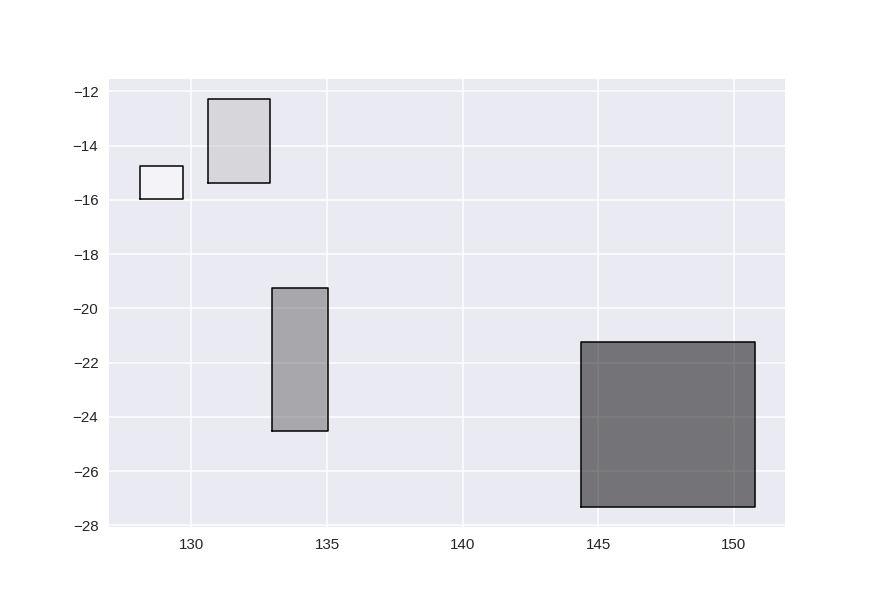

In [27]:
shape_df.plot()

In [28]:
##This is set up for the GW shapefiles. If your attribute table is different, YMMV 
with fiona.open(shape_file) as shapes:
    i = int(input("choose the index of the shape you would like to plot:"))
    geom_crs = geometry.CRS(shapes.crs_wkt)
    first_geo = shapes[i]['geometry']
    #first_geo = next(shapes)['geometry']
    #geopolygon = geometry.Geometry(geom, geom_crs)
    geom = geometry.Geometry(first_geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    name = shape_df['Survey'][i]
    shape_name='_'.join(name.split())
    print(shape_name)

choose the index of the shape you would like to plot:1
Northern_Stuart_Corridor


#Define temporal range

In [29]:
start_of_epoch = '1987-10-01'
#need a variable here that defines a rolling 'latest observation'  
end_of_epoch =  '2012-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2012-10-01


In [30]:
query = {
        'time': (start_of_epoch, end_of_epoch),
#          'x': (geom.bounds[0], geom.bounds[2]),
#          'y': (geom.bounds[1], geom.bounds[3]),
        'geopolygon': geom 
#         'crs': geom_crs,
    }

## Load `bom_rainfall` grids from the datacube (or from file)

In [31]:
#setup rain directory for our pickle data
rainpath ='/g/data/r78/rjd547/groundwater_activities/Rain/{}_{}_{}/'.format(shape_name,start_of_epoch,end_of_epoch)


In [32]:
try:
        os.mkdir(rainpath)
except OSError as err:
        print("OS error: {0}".format(err))
print('saving rainfall grid data to', rainpath)

OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Rain/Northern_Stuart_Corridor_1987-10-01_2012-10-01/'
saving rainfall grid data to /g/data/r78/rjd547/groundwater_activities/Rain/Northern_Stuart_Corridor_1987-10-01_2012-10-01/


In [33]:
try:
    #try to get the rain data from a pickle file saved earlier
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'rb')
    rain = pickle.load(f)
    Studysite_rain = rain['Studysite_rain']
    print('loaded rainfall grids from file:'+rainpath+'Rainfall_data.pkl')
    f.close()
except:
    #Grab bom_rainfall_grids from the datacube
    print('loading bom rainfall grids from datacube')
    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save
    vars2pickle = {'Studysite_rain':Studysite_rain}
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    print('saving rainfall data to file')
    #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loaded rainfall grids from file:/g/data/r78/rjd547/groundwater_activities/Rain/Northern_Stuart_Corridor_1987-10-01_2012-10-01/Rainfall_data.pkl


## Resample to yearly values, using the mean
The totally yearly rainfall (or sum over time) would seem to make sense, but our first and last year are incomplete, and are thus not able to be compared to all the others. It's nicer to not lose the data from them by using mean, rather than excluding them.

<IPython.core.display.Javascript object>


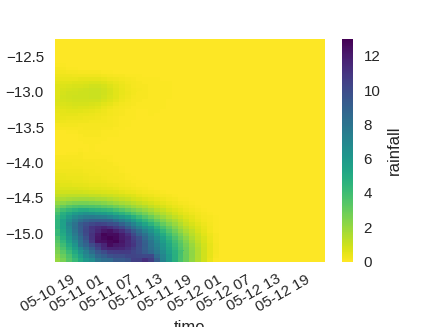

In [34]:
#Mask the data with the polygon. Invert = True means you want the contents of the mask
#I've added 'all touched = True, otherwise we get nothing in the output.
mask = geometry_mask([geom], Studysite_rain.geobox, all_touched=True,invert=True)
Studysite_rain_masked = Studysite_rain.where(mask)
#Plot at t[-1]
plt.figure(figsize=(4,3))
fig = Studysite_rain_masked.rainfall.isel(time = [19]).plot()
#reverse the colourmap so high rainfall is blue
fig.set_cmap('viridis_r')
#print (Studysite_rain_masked)
plt.show()

In [35]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
year_avg = Studysite_rain_masked.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)

## Plot rainfall by year

In [36]:
year_avg.rainfall.mean(dim=('latitude', 'longitude')).plot()
plt.show()

In [37]:
#minimum yearly value in space for each year
driest_mm = year_avg.min(dim = 'time', keep_attrs = True)
#print(driest_mm)

<IPython.core.display.Javascript object>


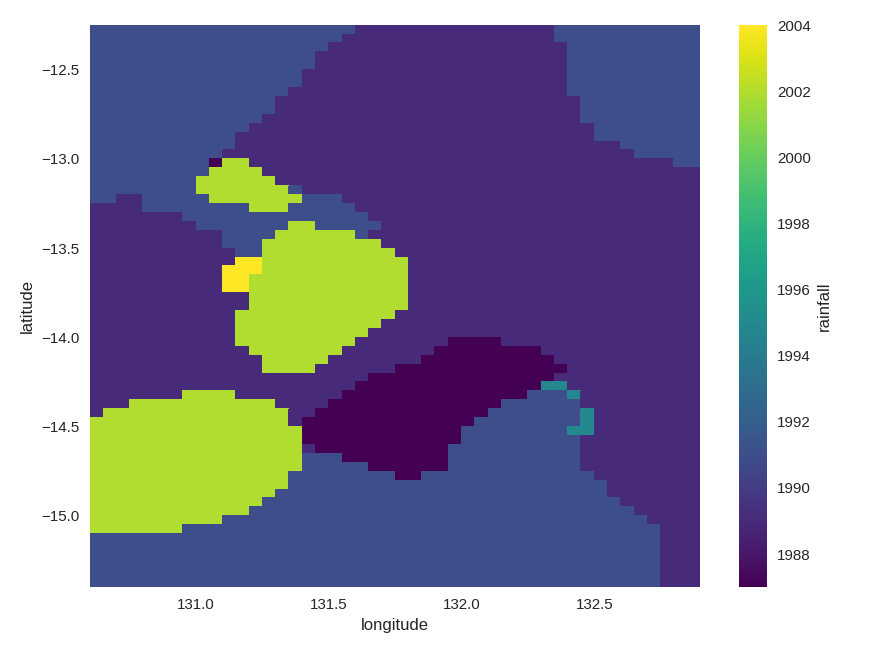

In [38]:
# Calculate the index of the minimum value through time
# Need to work in numpy/masked array land because we have entire time slices that are nan

m = year_avg.rainfall.where(year_avg.rainfall != 0).to_masked_array()
#m[m == 0] = np.inf
# idx = np.nanargmin(m, axis=0)
idx = m.argmin(axis=0, fill_value=-100)

# re-mask our data
idx = np.ma.array(idx, mask=np.all(m.mask, axis=0))

# Plug our indexes back into xarray.DataArray land
dates = year_avg.rainfall.any(dim='time',keep_attrs=True).copy() # Make a temp xarray dataset to keep the coordinates and plug our data in
#note that we start at 1987 now! 
dates.data = idx + 1987

# Mask out data that we know to be null/NaN
valid_values = year_avg.rainfall.notnull().all(dim='time')
dates = dates.where(valid_values)

# Print and plot the data
#print(dates)
plt.figure(figsize=(8,6))

#how many years in the time series?
years = (year_avg.rainfall.time.size)

#separate the colour map into n years
dates.plot()
plt.tight_layout()
plt.show()

#try this with a moving average

<IPython.core.display.Javascript object>


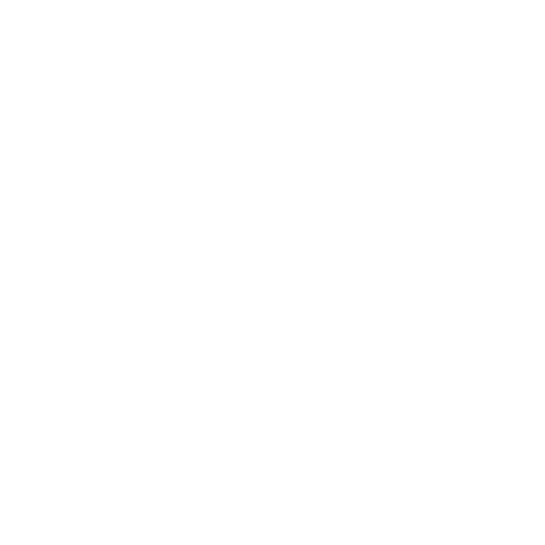

In [39]:
# Resample to monthly data + take the means
monthly_avg = Studysite_rain_masked.groupby('time.month').mean()

# Draw up a bar chart for this site showing the rainfall climatology

fig, ax = plt.subplots(figsize=(5,5))
width=0.8
plt.bar(monthly_avg.month -1,monthly_avg.rainfall, width = width)

# Setting the x-axis and y-axis limits
#plt.xlim([-0.5, 12.2])
#plt.xlim([0, 11.8])
#if monthly_avg.rainfall.max() >= 10:
#    plt.ylim([0, 20])
#else:
#    plt.ylim([0, 10])

# Set the y axis label
ax.set_ylabel('Rainfall (average mm/day?/month)')
ax.set_yticks(np.arange(0,int((max(monthly_avg.rainfall))+1),0.5))
#plt.title(Studysite.Name + ' monthly average daily rainfall 1986 - 2016')

# Set the labels for the x ticks
ax.set_xticks(np.arange(len(monthly_avg.month)) + width/2)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'])

plt.tight_layout()
plt.show()

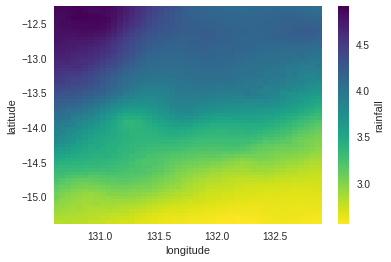

In [40]:
#make a plot of average daily rainfall across the region
%matplotlib inline
fig = Studysite_rain_masked.rainfall.mean(dim = 'time').plot()
fig.set_cmap('viridis_r')
plt.show()

####  Now we have the data, resample it to get a yearly average. 
See http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases for  resampling options

In [41]:
#check that the starting and ending times are what we expect
# Change the format so that it's YYYY-MM-DD
print ('start of rainfall data', np.array(year_avg.isel(time=[0]).time, dtype = 'datetime64[D]'))
print ('end of rainfall data', np.array(year_avg.isel(time=[-1]).time, dtype = 'datetime64[D]'))

start of rainfall data ['1987-10-01']
end of rainfall data ['2011-10-01']


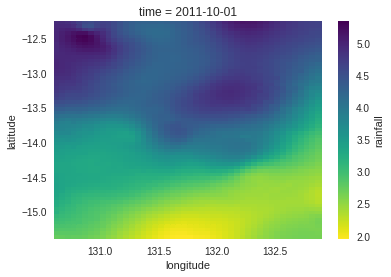

In [42]:
%matplotlib inline
# Plot values across our box to check the spatial distribution
plt.figure()
year_avg.isel(time = -1).rainfall.plot().set_cmap('viridis_r')
plt.show()


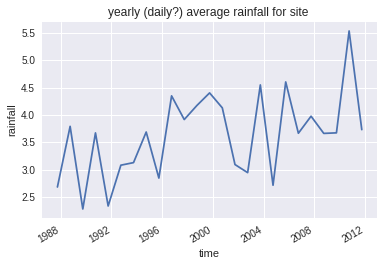

<xarray.Dataset>
Dimensions:   (time: 25)
Coordinates:
  * time      (time) datetime64[ns] 1987-10-01 1988-10-01 1989-10-01 ...
Data variables:
    rainfall  (time) float32 2.6825 3.79032 2.28089 3.67053 2.33558 3.08089 ...


In [43]:
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))
year_avg_sp.rainfall.plot()
plt.title('yearly (daily?) average rainfall for site ')#+str(Studysite[0]))
plt.show()
print(year_avg_sp)

In [44]:
# Find the 95th percentile in rainfall
threshold95 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 95)
# Find the 5th percentile in rainfall (least)
threshold5 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 5)
print('5th  q: ',threshold5.rainfall.values,'\n'+'95th q: ',threshold95.rainfall.values )

5th  q:  2.404960680007935 
95th q:  4.590683937072754


In [45]:
#work out which of the years have rainfall less than
wet_yrs = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).dropna(dim = 'time')
dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

#turn into numpy datetimes for later timeslicing
wet_dt=np.array(wet_yrs.time.values,dtype = 'datetime64[M]')
dry_dt=np.array(dry_yrs.time.values,dtype = 'datetime64[M]')

#print out our wet and dry years
print('wet years begin: ', wet_dt)
print('dry years begin: ', dry_dt)

#type(wet_dt[0])

wet years begin:  ['2005-10' '2010-10']
dry years begin:  ['1989-10' '1991-10']


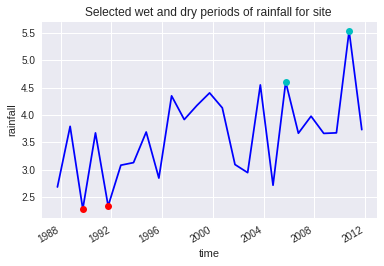

In [46]:
#Make a plot of the years we have chosen
year_avg_sp.rainfall.plot(color = 'b')
#here we index the dataset to plot the selected wet and dry years on top
wet1 = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).rainfall.plot(color ='c', marker ='o')
dry1 = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).rainfall.plot(color = 'r', marker = 'o')
#FIXME fix the x ticks at some point
#plt.xticks(np.arange(1))
#print(ticker.get_xlim())
plt.title('Selected wet and dry periods of rainfall for site ')#+str(Studysite[0]))
plt.show()


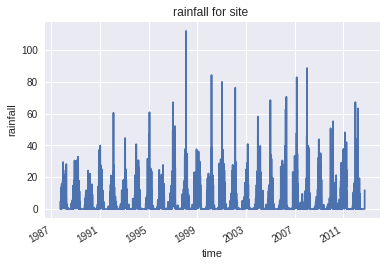

<xarray.Dataset>
Dimensions:   (time: 9132)
Coordinates:
  * time      (time) datetime64[ns] 1987-10-01 1987-10-02 1987-10-03 ...
Data variables:
    rainfall  (time) float32 4.72568 0.334128 1.27456e-06 0.161049 0.0383621 ...

In [47]:
#make a plot of rainfall for the wet and dry years that we have picked in here.
#first take a spatial average in lat and long 
rain_sp = Studysite_rain_masked.mean(dim = ('latitude','longitude'))
rain_sp.rainfall.plot()
plt.title('rainfall for site ')#+str(Studysite[0]))
plt.show()
rain_sp

In [48]:
print (max(rain_sp.rainfall))

<xarray.DataArray 'rainfall' ()>
array(112.0673828125, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-01-27


In [49]:
type(rain_sp.rainfall.time.data[0])

numpy.datetime64

In [50]:
#make a plot of rainfall for the wet and dry years that we have picked in here.
#first take a spatial average in lat and long 
#then resample to get monthly averages?
rain_sp = Studysite_rain_masked.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')

In [51]:
#select the months which are in our years
wet_dt
#print(wet_dt[0]+np.timedelta64(1,'Y'))

#set up end of years to finish our plots
end_wetyr = (wet_dt+np.timedelta64(1,'Y'))
#print(end_wetyr)
end_dryyr = (dry_dt+np.timedelta64(1,'Y'))

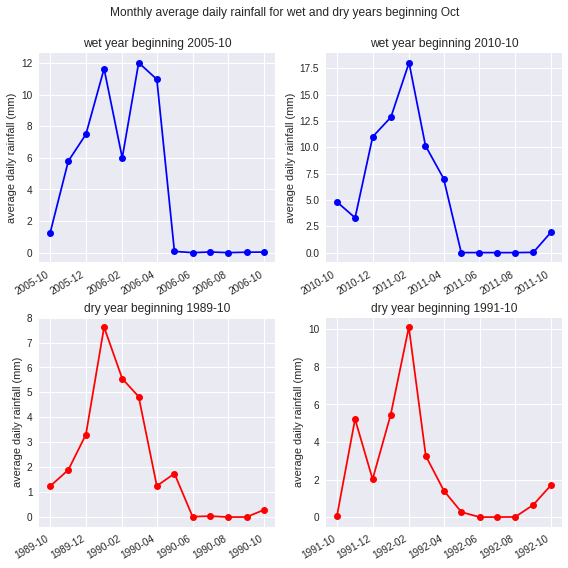

In [52]:
#set up 4 subplots to plot our 4 years
fig, axes = plt.subplots(nrows=2, ncols =2, figsize = (8,8))
#fig.suptitle('Monthly average daily rainfall for site '+str(Studysite[0]), fontsize = '14')

for i in range (0, len(wet_dt)):
    year_wrange = month_sp.rainfall.sel(time=slice(wet_dt[i],end_wetyr[i]))   
    #print(year_wrange.time.data)
    axes[0,i].plot(year_wrange.time.data, year_wrange.data, color='b', marker='o')
    axes[0,i].set_title('wet year beginning '+str(wet_dt[i]))
    axes[0,i].xaxis.set_label_position('bottom')
    axes[0,i].set_ylabel('average daily rainfall (mm)')
#     axes[0,i].set_ylim(0,12)
    #axes[0,i].set_ylim(0,20)

for i in range (0, len(dry_dt)):
    year_drange = month_sp.rainfall.sel(time=slice(dry_dt[i],end_dryyr[i]))
    #print(year_drange.time.data)
    axes[1,i].plot(year_drange.time.data,year_drange.data, color ='r', marker = 'o')
    axes[1,i].set_title('dry year beginning '+str(dry_dt[i]))
    axes[1,i].xaxis.set_label_position('bottom')
    axes[1,i].set_ylabel('average daily rainfall (mm)')
#     axes[1,i].set_ylim(0,12)
    #xes[1,i].set_xticks(np.r_drange.time.data)
    #axes[1,i].set_yticks(0,20,1)
    
#makes the labels the right angle
for ax in axes.ravel():
    for label in ax.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
        
#add an extra pad around the graphs so the titles don't overlap        
plt.tight_layout(h_pad =1.0)
plt.subplots_adjust(top= 0.9)
plt.suptitle('Monthly average daily rainfall for wet and dry years beginning Oct')
plt.show()


Save rainfall years to netcdf and geotiff

In [53]:
#get the original dataset attributes (crs)
#set up variable attributes to hold the attributes from Studysite_rain
attrs = Studysite_rain
#dump the rain info
rain_data = attrs.data_vars.keys()
for i in rain_data:
    #drop band data, retaining just the attributes
    attrs =attrs.drop(i)
#set up new variable called rain_var, and assign attributes to it in a dictionary
rain_vars = {'dates':''}
dates_data = attrs.assign(**rain_vars)
dates_data['dates'] = dates

This section only needs to be run when you want to create the netcdf and geotiff files the first time.
There is a way to do this in python using gdal but this is quick and reliable.

In [54]:
#set up outfilename
ncpath = '/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)
filename = ncpath+'.nc'

In [55]:
filename

'/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.nc'

write to netcdf format

In [56]:
try:
    write_dataset_to_netcdf(dates_data,variable_params={'dates': {'zlib':True}},filename=filename)
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))

RuntimeError: Storage Unit already exists: /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.nc


using the gdal translate utility write the netcdf file to GeoTiff format

In [ ]:
#__________________________________##

Here is where you need to make changes for each shapefile

In [58]:
!module load gdal
!gdal_translate /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.nc /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.tif

Input file size is 46, 63
0...10...20...30...40...50...60...70...80...90...100 - done.


In [59]:
#open our GTiff with gdal
date_gt =gdal.Open(filename)
gdal.UseExceptions()
band = date_gt.GetRasterBand(1)
vals = band.ReadAsArray()
array = date_gt.ReadAsArray()
nodata = band.GetNoDataValue()

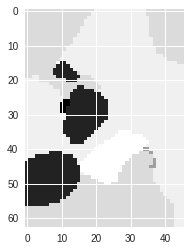

In [60]:
#check our tif worked
msk = vals==nodata
date_arr = np.ma.array(data=vals, mask=msk, fill_value=np.nan) 
plt.imshow(date_arr)
plt.show()

check our dates and create a mask for nodata values

In [61]:
vals = vals.astype('int32')
vals[vals != -999]
print(vals)
#for validation, check that the histogram of the dates is ok
hist, bins = np.histogram(vals, range=(1986, 2014), bins=len(range(1986, 2014)))
print(hist)
#build a mask to mask nodata values when we create a shapefile
msk2 = mask.astype('uint8')
mask

[[1991 1991 1991 ..., 1991 1991 1991]
 [1991 1991 1991 ..., 1991 1991 1991]
 [1991 1991 1991 ..., 1991 1991 1991]
 ..., 
 [1991 1991 1991 ..., 1989 1989 1989]
 [1991 1991 1991 ..., 1989 1989 1989]
 [1991 1991 1991 ..., 1989 1989 1989]]
[   0  167    0 1335    0  986    0    0    0    7    0    0    0    0    0
    0  394    0    9    0    0    0    0    0    0    0    0    0]


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [62]:
#set up a filename stub so don't have to type it all the time:
filename_start=filename.split('.')[0]
print(filename_start)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01


In [63]:
#create another tif file as a masking file 
with rasterio.open(filename_start+'.tif') as ds:
    jcrs = ds.crs
    jtransform = ds.transform
    
kwargs = {'count': 1, 'height': msk2.shape[0], 'width': msk2.shape[1], 'driver': 'GTiff',
          'dtype': 'uint8', 'crs': jcrs, 'transform': jtransform}
with rasterio.open(filename_start+'-mask.tif', 'w',
                   **kwargs) as outds:
    outds.write(msk2, 1)
print('wrote mask file: ', filename_start+'-mask.tif')

wrote mask file:  /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01-mask.tif


In [64]:
#check that the files are in (your) directory:

In [67]:
#check that the files are in (your) directory:
!ls /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/*.tif

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_East_Kimberley_1987-10-01_2012-10-01-mask.tif
/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_East_Kimberley_1987-10-01_2012-10-01.tif
/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01-mask.tif
/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.tif
/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.tif


filter out polygons of less than 10 x 10 pixels

In [66]:
# # # filter out polygons of less than 10 x 10 pixels
!gdal_sieve.py -st 10 -4 /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01.tif -mask /g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2-mask.tif /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


create a shapefile of output polygons

#create a shapefile of output polygons
change the masking file to the one you have created, change the sieved file to the new one, then give the new shapefile a name

In [68]:
 #create a shapefile of output polygons
#!gdal_polygonize.py -mask [maskfile.tif] [inputfile.tif]-f "ESRI Shapefile" [outputfile.shp]
!gdal_polygonize.py -mask /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01-mask.tif /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.tif -f "ESRI Shapefile" /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.shp

Creating output /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


# have a look at the final result to see if it looks ok!

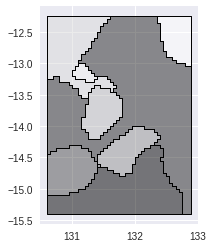

In [69]:
import geopandas as gpd
#big_poly = gpd.read_file('/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_East_Kimberley_1987-10-01_2012-10-01.shp')
big_poly = gpd.read_file('/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.shp')
big_poly.plot()
plt.show()

In [70]:
big_poly

,DN,geometry
0,1991,"POLYGON ((132.35 -12.25, 132.9 -12.25, 132.9 -..."
1,2002,"POLYGON ((131.1 -13, 131.2 -13, 131.2 -13.05, ..."
2,1991,"POLYGON ((130.6 -12.25, 131.6 -12.25, 131.6 -1..."
3,2002,"POLYGON ((131.35 -13.35, 131.45 -13.35, 131.45..."
4,1987,"POLYGON ((131.95 -14, 132.15 -14, 132.15 -14.0..."
5,1989,"POLYGON ((131.4 -14.6, 131.45 -14.6, 131.45 -1..."
6,2002,"POLYGON ((130.95 -14.3, 131.15 -14.3, 131.15 -..."
7,1989,"POLYGON ((131.6 -12.25, 132.35 -12.25, 132.35 ..."
8,1991,"POLYGON ((132.25 -14.3, 132.4 -14.3, 132.4 -14..."


# at the end of this notebook, you should have a functioning shapefile with polygons of common dry years based on the average daily dry season rainfall for each area. This shapefile can then be gridded in QGIS and run through "Regional Wettest Driest" notebook to get percentile wettest and driest rainfall years.